In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tueplots import bundles, figsizes

plt.rcParams.update(bundles.icml2022()) 
plt.rcParams.update(figsizes.icml2022_half())
plt.rcParams["text.usetex"] = True

In [12]:
# Apply ICML-like style for consistency with LaTeX templates
style = bundles.icml2024(usetex=True, family="serif")
plt.rcParams.update(style)

# TU Corporate Colors
TU_RED = "#d95f02"
TU_GRAY = "#AFB3B7"

# WHO countries by region
WHO_COUNTRIES = {
    "AFR": ["Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cameroon", "Cape Verde", "Cabo Verde", "Central African Republic", "Chad", "Comoros", "Ivory Coast", "Democratic Republic of the Congo", "Equatorial Guinea", "Eritrea", "Ethiopia", "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Mozambique", "Namibia", "Niger", "Nigeria", "Republic of the Congo", "Rwanda", "São Tomé and Príncipe", "Senegal", "Seychelles", "Sierra Leone", "South Africa", "South Sudan", "Eswatini", "Togo", "Uganda", "Tanzania", "Zambia", "Zimbabwe"],
    "AMR": ["Peru", "Paraguay", "Saint Kitts and Nevis", "Antigua and Barbuda", "Argentina", "Bahamas", "Barbados", "Belize", "Bolivia", "Brazil", "Canada", "Chile", "Colombia", "Costa Rica", "Cuba", "Dominica", "Dominican Republic", "Ecuador", "El Salvador", "Grenada", "Guatemala", "Guyana", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama", "Saint Lucia", "Saint Vincent and the Grenadines", "Suriname", "Trinidad and Tobago", "the United States of America", "Uruguay", "Venezuela"],
    "SEAR": ["Bangladesh", "Bhutan", "Democratic People's Republic of Korea", "India", "Maldives", "Myanmar", "Nepal", "Sri Lanka", "Thailand", "Timor-Leste"],
    "EUR": ["Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Israel", "Italy", "Kazakhstan", "Kyrgyzstan", "Latvia", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro", "Netherlands", "North Macedonia", "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Tajikistan", "Turkey", "Turkmenistan", "Ukraine", "United Kingdom", "Uzbekistan"],
    "EMR": ["Libya", "Afghanistan", "Bahrain", "Djibouti", "Egypt", "Iran", "Iraq", "Jordan", "Kuwait", "Israel", "Oman", "Pakistan", "Qatar", "Saudi Arabia", "Somalia", "Sudan", "Syria", "Tunisia", "United Arab Emirates", "Yemen", "Morocco"],
    "WPR": ["Australia", "Brunei", "Cambodia", "China", "Cook Islands", "Fiji", "Indonesia", "Japan", "Kiribati", "Laos", "Malaysia", "Marshall Islands", "Micronesia", "Mongolia", "Nauru", "New Zealand", "Niue", "Palau", "Papua New Guinea", "Philippines", "Samoa", "Singapore", "Solomon Islands", "South Korea", "Taiwan", "Tonga", "Tuvalu", "Vanuatu", "Vietnam"]
}

# Name recoding for variations in country names
NAME_RECODE = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Brunei Darussalam": "Brunei",
    "Côte d'Ivoire": "Ivory Coast",
    "Czechia": "Czech Republic",
    "Lao People's Democratic Republic": "Laos",
    "Republic of Moldova": "Moldova",
    "Russian Federation": "Russia",
    "Sao Tome and Principe": "São Tomé and Príncipe",
    "Türkiye": "Turkey",
    "United States of America": "the United States of America",
    "Micronesia (Federated States of)": "Micronesia",
    "Netherlands (Kingdom of the)": "Netherlands",
    "Republic of Korea": "South Korea",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "United Republic of Tanzania": "Tanzania"
}

# =============================================================================
# Data Preparation
# =============================================================================

# Read the vaccination data (assuming full dataset for time series)
vax = pd.read_csv("who_vax_country.tsv", sep="\t", header=0)

# Subset for specific antigen description
vax = vax[vax['ANTIGEN_DESCRIPTION'] == "HPV Vaccination program coverage, first dose, females"]

# Convert COVERAGE to integer
vax['COVERAGE'] = vax['COVERAGE'].astype('Int64')

# Recode the NAME column
vax['NAME'] = vax['NAME'].replace(NAME_RECODE)

# Create who_region_df
who_region_df = pd.DataFrame([
    (country, region) 
    for region, countries in WHO_COUNTRIES.items() 
    for country in countries
], columns=['NAME', 'REGION'])

# Join vax with who_region_df
vax = vax.merge(who_region_df, on='NAME', how='left')

# Read metadata
metadata = pd.read_csv("vax_metadata.csv", index_col=0)  # Adjust path if necessary
metadata = metadata.rename(columns={'ISO_3_CODE': 'CODE'})
metadata_selected = metadata[['CODE', 'HPV_YEAR_INTRODUCTION', 'HPV_INT_DOSES']]

# Join vax with metadata_selected
vax = vax.merge(metadata_selected, on='CODE', how='left')

# Update COVERAGE based on conditions
vax['COVERAGE'] = np.where(
    (vax['YEAR'] < vax['HPV_YEAR_INTRODUCTION']) | 
    (vax['HPV_INT_DOSES'] == "Not yet introduced"),
    0,
    vax['COVERAGE']
)

# Drop the HPV_YEAR_INTRODUCTION column
vax = vax.drop(columns=['HPV_YEAR_INTRODUCTION'])

# Convert YEAR to datetime upfront for consistency
vax["YEAR"] = pd.to_datetime(vax["YEAR"].astype(int), format='%Y')

# Recalculate vax_name (assumes COVERAGE already cleaned appropriately)
vax_name = vax.groupby(["REGION", "YEAR"]).agg(
    mean_coverage=("COVERAGE", "mean"),
    se_coverage=("COVERAGE", lambda x: 0 if x.notna().sum() <= 1 
                 else x.std(ddof=1) / np.sqrt(x.notna().sum()))
).reset_index()

# Convert REGION to categorical
vax_name["REGION"] = pd.Categorical(vax_name["REGION"])

c:\Users\ettod\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\ettod\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


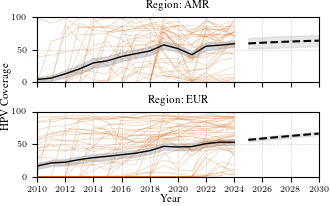

In [13]:
regions = ["AMR", "EUR"]

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
axes = axes.flatten()

for idx, region in enumerate(regions):
    ax = axes[idx]

    region_data = vax_name[vax_name["REGION"] == region].sort_values("YEAR")
    country_data = vax[vax["REGION"] == region]

    # Plot individual country lines
    for country in country_data["NAME"].unique():
        subset = country_data[country_data["NAME"] == country].dropna(subset=["COVERAGE"])
        ax.plot(subset["YEAR"], subset["COVERAGE"],
                color=TU_RED, alpha=0.3, linewidth=0.5)

    # Ribbon for ±SE
    ax.fill_between(region_data["YEAR"],
                    region_data["mean_coverage"] - region_data["se_coverage"],
                    region_data["mean_coverage"] + region_data["se_coverage"],
                    color=TU_GRAY, alpha=0.5)

    # Regional mean line
    ax.plot(region_data["YEAR"], region_data["mean_coverage"],
            color="black", linewidth=1, label="Regional Mean")

    # Forecast to 2030 only for AMR and EUR
    if region in ["AMR", "EUR"] and len(region_data) >= 2:
        ts = region_data.set_index("YEAR")["mean_coverage"]
        last_year = ts.index.max()
        horizon = 2030 - last_year.year

        if horizon > 0:
            try:
                model = ExponentialSmoothing(ts, trend="add", damped_trend=True).fit()
                forecast_years = pd.date_range(
                    start=last_year + pd.DateOffset(years=1),
                    end="2030-01-01", freq="YS"
                )
                forecast_mean = model.forecast(len(forecast_years))

                sims = model.simulate(
                    nsimulations=len(forecast_years),
                    repetitions=1000,
                    error="add"
                )
                lower = sims.quantile(0.05, axis=1)
                upper = sims.quantile(0.95, axis=1)

                # Forecast ribbon
                ax.fill_between(forecast_years, lower, upper, color=TU_GRAY, alpha=0.3)

                # Forecast mean dashed
                ax.plot(forecast_years, forecast_mean,
                        color="black", linestyle="--", linewidth=1.5)
            except Exception as e:
                print(f"Forecast failed for {region}: {e}")

    ax.set_title(f"Region: {region}")
    ax.set_ylim(0, 100)
    ax.set_xlim(vax["YEAR"].min(), pd.Timestamp("2030-01-01"))
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

# Common axis labels
fig.text(0.5, -0.02, "Year", ha="center")
fig.text(-0.02, 0.5, "HPV Coverage", va="center", rotation="vertical")
plt.savefig("C:\\Users\\ettod\\Tubingen_exercises\\DataL\\vax_year_pred.pdf", bbox_inches="tight")
plt.show()